# predict dress rating model

I use text mining to predict the rating of a dress from online reviews. Dresses reviews are positive (>3 stars) or neutral/negative (<4 stars)?


In [80]:
import pandas as pd
from pandas.api.types import is_numeric_dtype
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.naive_bayes import MultinomialNB
import re
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter
from collections import defaultdict
import nltk
from nltk.corpus import wordnet as wn
from nltk import pos_tag
nltk.download('wordnet')
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,recall_score,precision_score
from sklearn.naive_bayes import MultinomialNB
from string import punctuation

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Hoda\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Hoda\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Hoda\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [81]:
dresses_reviews = pd.read_csv('Assignment text mining - data clothing reviews.csv')
dresses_reviews.head()

,Unnamed: 0,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses


In [82]:
dresses_reviews['Class Name'].value_counts()

Dresses           6319
Knits             4843
Blouses           3097
Sweaters          1428
Pants             1388
Jeans             1147
Fine gauge        1100
Skirts             945
Jackets            704
Lounge             691
Swim               350
Outerwear          328
Shorts             317
Sleep              228
Legwear            165
Intimates          154
Layering           146
Trend              119
Casual bottoms       2
Chemises             1
Name: Class Name, dtype: int64

Pre-processing steps and filtering out non-dress reviews

In [83]:
df_reviews = dresses_reviews.loc[dresses_reviews['Class Name'] == 'Dresses']
df_reviews = df_reviews.dropna()
df_reviews['Class Name'].value_counts()

Dresses    5371
Name: Class Name, dtype: int64

In [84]:
df_reviews = df_reviews[['Review Text','Rating']]
df_reviews = df_reviews.rename(columns={"Review Text": "text", "Rating": "rating", "Recommended IND": "index"})
df_reviews.head(10)

,text,rating
2,I had such high hopes for this dress and reall...,3
5,"I love tracy reese dresses, but this one is no...",2
8,I love this dress. i usually get an xs but it ...,5
9,"I'm 5""5' and 125 lbs. i ordered the s petite t...",5
10,Dress runs small esp where the zipper area run...,3
12,More and more i find myself reliant on the rev...,5
14,This is a nice choice for holiday gatherings. ...,3
19,I love the look and feel of this tulle dress. ...,5
21,"I'm upset because for the price of the dress, ...",4
22,"First of all, this is not pullover styling. th...",2


Text(0, 0.5, 'samples')

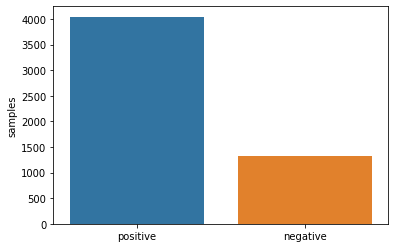

In [76]:
x = df_reviews['rating'].value_counts()
sns.barplot(x.index,x)
plt.gca().set_ylabel('samples')

In [85]:
is_numeric_dtype(df_reviews['rating'])
df_reviews.loc[df_reviews.rating >=4 , "rating"] = "positive"
df_reviews.loc[df_reviews.rating != "positive", "rating"] = "negative"
df_reviews.head(10)

,text,rating
2,I had such high hopes for this dress and reall...,negative
5,"I love tracy reese dresses, but this one is no...",negative
8,I love this dress. i usually get an xs but it ...,positive
9,"I'm 5""5' and 125 lbs. i ordered the s petite t...",positive
10,Dress runs small esp where the zipper area run...,negative
12,More and more i find myself reliant on the rev...,positive
14,This is a nice choice for holiday gatherings. ...,negative
19,I love the look and feel of this tulle dress. ...,positive
21,"I'm upset because for the price of the dress, ...",positive
22,"First of all, this is not pullover styling. th...",negative


# Text pre-processing steps

In [40]:
df_reviews.iloc[0]['text']

'I had such high hopes for this dress and really wanted it to work for me. i initially ordered the petite small (my usual size) but i found this to be outrageously small. so small in fact that i could not zip it up! i reordered it in petite medium, which was just ok. overall, the top half was comfortable and fit nicely, but the bottom half had a very tight under layer and several somewhat cheap (net) over layers. imo, a major design flaw was the net over layer sewn directly into the zipper - it c'

In [41]:
df_reviews['text']=df_reviews['text'].str.lower()
stop = stopwords.words('english')
df_reviews['text'] = df_reviews['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
df_reviews.head()

,text,rating
2,high hopes dress really wanted work me. initia...,negative
5,"love tracy reese dresses, one petite. 5 feet t...",negative
8,love dress. usually get xs runs little snug bu...,positive
9,"i'm 5""5' 125 lbs. ordered petite make sure len...",positive
10,dress runs small esp zipper area runs. ordered...,negative


In [44]:
def remove_special_characters(text):
    pattern=r'[^a-zA-Z\s]'
    text=re.sub(pattern,'',text)
    return text
def strip_punctuation(s):
    return ''.join(c for c in s if c not in punctuation)

df_reviews['text'] = df_reviews['text'].apply(remove_special_characters)
df_reviews['text'] = df_reviews['text'].apply(strip_punctuation)
df_reviews.head(10)

,text,rating
2,high hopes dress really wanted work me initial...,negative
5,love tracy reese dresses one petite feet tall...,negative
8,love dress usually get xs runs little snug bus...,positive
9,im lbs ordered petite make sure length long ...,positive
10,dress runs small esp zipper area runs ordered ...,negative
12,find reliant reviews written savvy shoppers pa...,positive
14,nice choice holiday gatherings like length gra...,negative
19,love look feel tulle dress looking something d...,positive
21,im upset price dress thought embroidered no pr...,positive
22,first all pullover styling side zipper purchas...,negative


# fiting model

In [46]:
#chang into unicode and Vectorizer to fit model
text = df_reviews['text'].values.astype('U')
vect = CountVectorizer(stop_words='english')
vect = vect.fit(text) 
feature_names = vect.get_feature_names()
print(f"There are {len(feature_names)} words in the vocabulary. A selection: {feature_names[500:520]}")

There are 8732 words in the vocabulary. A selection: ['badly', 'badso', 'baffled', 'bag', 'baggage', 'baggier', 'bagginess', 'bagging', 'baggish', 'baggy', 'baggybig', 'baglike', 'bags', 'bahamas', 'bailey', 'baily', 'bainbridge', 'balance', 'balanced', 'balances']


# matrix

resulting in a document-feature matrix

In [ ]:
#matrix
docu_feat = vect.transform(text)
print(docu_feat[0:500,0:500])

Train a Naïve Bayes classifier predicting

In [57]:
#Naiv Baye model
NB = MultinomialNB()
X = docu_feat #matrix X
y = df_reviews['rating'] #vector Y
#split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)
#X=features, y=character
NB = NB.fit(X_train, y_train)

# evaluating

In [68]:
#Evaluate the model
y_test_prediction = NB.predict(X_test)
NB.score(X_test, y_test)

0.8486352357320099

In [69]:
y_test_prediction

array(['positive', 'negative', 'positive', ..., 'positive', 'positive',
       'positive'], dtype='<U8')

In [70]:
cm = confusion_matrix(y_test, y_test_prediction)
cm = pd.DataFrame(cm, index=['negative', 'positive'], columns=['negative pred', 'positive pred'])
cm

,negative pred,positive pred
negative,225,181
positive,63,1143


In [71]:
NB.classes_

array(['negative', 'positive'], dtype='<U8')

In [72]:
df_reviews['rating_pred'] = pd.Series(y_test_p)
df_reviews.head(20)

,text,rating,rating_pred
2,high hopes dress really wanted work me initial...,negative,positive
5,love tracy reese dresses one petite feet tall...,negative,negative
8,love dress usually get xs runs little snug bus...,positive,positive
9,im lbs ordered petite make sure length long ...,positive,positive
10,dress runs small esp zipper area runs ordered ...,negative,negative
12,find reliant reviews written savvy shoppers pa...,positive,positive
14,nice choice holiday gatherings like length gra...,negative,positive
19,love look feel tulle dress looking something d...,positive,positive
21,im upset price dress thought embroidered no pr...,positive,positive
22,first all pullover styling side zipper purchas...,negative,negative
